In [4]:
from obspy import read_events, Catalog, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geothermie_plot_function import *

In [5]:
threshold_event_magnitude = 0.5

In [ ]:
catalog = read_events('Downloads/geothermie-events-master/geothermie-events-master/Unterhaching/*.xml')
catnew = Catalog()
cat2013 = Catalog()
eventinfo = []
eventinfo2 = []
for event in catalog:
    try:
        if not (event.origins[0]['time'] > UTCDateTime(2013,1,1) and event.origins[0]['time'] < UTCDateTime(2014,1,1)):
            catnew.append(event)
            eventinfo.append([event.origins[0]['time'],event.magnitudes[0].mag])
        else:
            cat2013.append(event)
            eventinfo2.append([event.origins[0]['time'],event.magnitudes[0].mag])
    except:
        pass
catalog = catnew
roundedtimes = []
magnitudes = []
for time in eventinfo:
    rtime = float(UTCDateTime(time[0].year,time[0].month,time[0].day,time[0].hour))
    roundedtimes.append(rtime)
    magnitudes.append(time[1])
roundedtimes, magnitudes = zip(*sorted(zip(roundedtimes, magnitudes)))
print(catalog)
names = 'Time,Flowrate,Temperature,Pressure'
names = names.split(",")
data = pd.read_csv('Dokumente/unterhaching_betriebsdaten_2008-2017/daten20082017.txt',names=names,skiprows=1,delimiter=' ')
N = len(data)
newcol = np.zeros(N)
newcol2 = np.zeros(N)
flc = np.zeros(N)
tc = np.zeros(N)
pc = np.zeros(N)

ievent = 0

eventtimes = np.zeros(N)
eventtimes[0] = 100*365*24
eventtimes[1] = eventtimes[0]+1
newcol2[0] = np.nan
for i in range(1,N):
    if data['Time'][i] in roundedtimes:
        newcol[i] = 1
        N_events_in_this_hour = roundedtimes.count(data['Time'][i])
        
        ## get top magnitude of events in this hour
        mag = max(magnitudes[ievent:ievent+N_events_in_this_hour])
        newcol2[i] = mag
        if mag > threshold_event_magnitude:
            eventtimes[i+1] = 0
        else:
            eventtimes[i+1] = eventtimes[i]+1
        
        ievent += N_events_in_this_hour
    else:
        newcol2[i] = np.nan
        if i!=N-1:
            eventtimes[i+1] = eventtimes[i]+1
        
            
    
    if i==43022:
        roundedtimes2 = []
        magnitudes2 = []
        for time in eventinfo2:
            rtime = float(UTCDateTime(time[0].year,time[0].month,time[0].day,time[0].hour))
            roundedtimes2.append(rtime)
            magnitudes2.append(time[1])
        roundedtimes2, magnitudes2 = zip(*sorted(zip(roundedtimes2, magnitudes2)))
        roundedtimes2 = list(roundedtimes2)
        magnitudes2 = list(magnitudes2)
        roundedtimes2.reverse()
        magnitudes2.reverse()
        check = True
        mag = -100
        eventindex = -1
        while (mag < threshold_event_magnitude and check):
            eventindex += 1
            mag = magnitudes2[eventindex]
            if eventindex==len(magnitudes2):
                check = False
        eventtimes[i] = (float(UTCDateTime(2014,1,1))-roundedtimes2[eventindex])/(60**2)

drop = []
for i in range(N):
    if np.isnan(data['Flowrate'][i]):
        drop.append(i)
data.drop(drop)
N = len(data)

for i in range(1,N-1):
    flc[i] = data['Flowrate'][i+1]-data['Flowrate'][i-1]
    tc[i] = data['Temperature'][i+1]-data['Temperature'][i-1]
    pc[i] = data['Pressure'][i+1]-data['Pressure'][i-1]
    

#data['Flowrate diff'] = flc/2
#data['Temp diff'] = tc/2
#data['Press diff'] = pc/2
data['Quiet time'] = eventtimes
data['Event'] = newcol
data['Magnitude'] = newcol2
names.extend(['Flowrate diff','Temp diff','Press diff','Quiet time','Event','Magnitude'])

In [ ]:
def Confusionmatrix(y,yhat,perc):
    N = len(y)
    C = [[0,0],[0,0]]
    for i in range(N):
        if y[i,0]==1. and yhat[i,0]>=perc:
            C[0][0] += 1
        elif y[i,0]==0. and yhat[i,0]>=perc:
            C[1][0] += 1
        elif y[i,0]==1. and yhat[i,0]<perc:
            C[0][1] += 1
        else:
            C[1][1] += 1
            
    print('True Positives:  ', C[0][0])
    print('False Positives: ', C[1][0])
    print('False Negatives: ', C[0][1])
    print('True Negatives:  ', C[1][1])
    return C

In [ ]:
def plot_model_evolution(Loss,b,c,U,V,W):
    fig,ax = plt.subplots(nrows=6,figsize=(15,15),sharex=True)
    ax[0].plot(Loss,label='Loss')
    ax[0].set_yscale('log')
    ax[1].plot(c[:,0],label='c1')
    ax[1].plot(c[:,1],label='c2')
    ax[2].plot(b[:,0],label='b1')
    ax[2].plot(b[:,1],label='b2')
    ax[2].plot(b[:,2],label='b3')
    ax[3].plot(V[:,0,0],label='V11')
    ax[3].plot(V[:,0,1],label='V12')
    ax[3].plot(V[:,0,2],label='V13')
    ax[3].plot(V[:,1,0],label='V21')
    ax[3].plot(V[:,1,1],label='V22')
    ax[3].plot(V[:,1,2],label='V23')
    
    ulabels = [['U11','U12','U13'],['U21','U22','U23'],['U31','U32','U33']]
    wlabels = [['W11','W12','W13'],['W21','W22','W23'],['W31','W32','W33']]
    
    for i in range(3):
        for j in range(3):
            ax[4].plot(U[:,i,j],label=ulabels[i][j])
            ax[5].plot(W[:,i,j],label=wlabels[i][j])
            
    for i in range(6):
        ax[i].legend(fontsize=8)
    plt.show() 

In [ ]:
def softmax(xx):
    z = np.zeros(len(xx))
    summa = 0
    for i in range(len(xx)):
        z[i] = np.exp(xx[i])
        summa += np.exp(xx[i])
    return z/summa

In [ ]:
def ReLu(xx):
    zz = np.zeros(len(xx))
    for i in range(len(xx)):
        if xx[i]>0:
            zz[i] = xx[i]
    return zz

In [ ]:
def delta(xx,yy):
    if xx==yy:
        return 1.
    else:
        return 0.

In [ ]:
def initialization(Nit):

    U = np.zeros((Nit,3,3))
    W = np.zeros((Nit,3,3))
    b = np.zeros((Nit,3))
    V = np.zeros((Nit,2,3))
    c = np.zeros((Nit,2))

    dU = np.zeros((Nit,3,3))
    dW = np.zeros((Nit,3,3))
    db = np.zeros((Nit,3))
    dV = np.zeros((Nit,2,3))
    dc = np.zeros((Nit,2))

    yhat = np.zeros((Nit+1,N,2))

    Nrandom = 1000

    for i in range(3):
        for j in range(3):
            U[0,i,j] = np.random.randint(0,Nrandom)/Nrandom 
            W[0,i,j] = np.random.randint(0,Nrandom)/Nrandom 
        b[0,i]= np.random.randint(0,Nrandom)/Nrandom   
    for i in range(2):
        for k in range(3):
            V[0,i,k] = np.random.randint(0,Nrandom)/Nrandom 
        c[0,i] = np.random.randint(0,Nrandom)/Nrandom     

    Loss = np.zeros(Nit)

    return U,W,b,V,c,dU,dW,db,dV,dc,yhat,Loss

In [ ]:
def prediction(b,c,U,V,W,x):
    N = len(x)
    a = np.zeros((N,3))
    h = np.zeros((N,3))
    o = np.zeros((N,2))
    yhat = np.zeros((N,2))
    a[0] = b + np.dot(U,x[0])
    h[0] = np.tanh(a[0])
    o[0] = c + np.dot(V,h[0])
    for t in range(0,N):
        a[t] = b + np.dot(W,h[t-1])+np.dot(U,x[t])
        h[t] = np.tanh(a[t])
        o[t] = c + np.dot(V,h[t])
        yhat[t,:] = softmax(o[t,:])
    return h,o,yhat

def get_loss(y,yhat):
    N = len(y)
    Loss = 0
    for t in range(N):
        Loss -= y[t,0]*np.log10(yhat[t,0])+(1-y[t,0])*np.log10(yhat[t,1])
    return Loss

def gradients(h,o,V,W,x,y,yhat):
    N = len(x)
    do = np.zeros((N,2))
    for t in range(N):
        do[t,0] = y[t,0]*(1-yhat[t,0])-yhat[t,0]*(1-y[t,0])
        do[t,1] = -y[t,0]*yhat[t,1] * (1-y[t,0])*(1-yhat[t,1])
    do /= np.log(10)
    
    dh = np.zeros((N,3))
    dh[-1] = np.dot(V.transpose(),do[-1])
    for t in range(N-2,-1,-1):
        diag = np.diag(np.array([1-h[t+1,0]**2,1-h[t+1,1]**2,1-h[t+1,2]**2]))
        dh[t] = np.dot(np.dot(W.transpose(),diag),dh[t+1])+np.dot(V.transpose(),do[t])

    dc = np.zeros(2)
    for i in range(2):
        dc[i] = np.sum(do[:,i])
    db = np.zeros(3)
    dV = np.zeros((2,3))
    dW = np.zeros((3,3))
    dU = np.zeros((3,3))
    for i in range(3):
        for t in range(N):
            db[i] += (1-h[t,i]**2)*dh[t,i]
    
    for t in range(N):
        dV[0,0] += do[t,0]*h[t,0]
        dV[1,0] += do[t,1]*h[t,0]
        dV[0,1] += do[t,0]*h[t,1]
        dV[1,1] += do[t,1]*h[t,1]
        dV[0,2] += do[t,0]*h[t,2]
        dV[1,2] += do[t,1]*h[t,2]

    for t in range(1,N):
        mat = np.zeros((3,3))
        mat2 = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                mat[i,j] = dh[t,i] * h[t-1,j]
                mat2[i,j] = dh[t,i] * x[t,j]
        dW += np.dot(np.diag(np.array([1-h[t,0]**2,1-h[t,1]**2,1-h[t,2]**2])),mat)
        dU += np.dot(np.diag(np.array([1-h[t,0]**2,1-h[t,1]**2,1-h[t,2]**2])),mat2)
    return db,dc,do,dU,dV,dW

In [ ]:
def mapx(x):
    Nt, Ni = np.shape(x)
    m = np.zeros((Ni,2))
    for i in range(Ni):
        m[i,0] = np.min(x[:,i])
        m[i,1] = np.max(x[:,i])
    newx = np.zeros(np.shape(x))
    for i in range(Ni):
        for t in range(Nt):
            newx[t,i] = (x[t,i]-m[i,0])/(m[i,1]-m[i,0])
    return newx

In [ ]:
#data acquisition
N = len(data)
x = [[],[],[]]
y = [[],[]]
index = 0
for i in range(N):
    if not np.isnan(data['Flowrate'][i]):
        x[0].append(data['Flowrate'][i])
        x[1].append(data['Temperature'][i])
        x[2].append(data['Pressure'][i])
        y[0].append(data['Event'][i])
        y[1].append(data['Magnitude'][i])
x = np.array(x).transpose()
y = np.array(y).transpose()
x = mapx(x)
N = len(x)

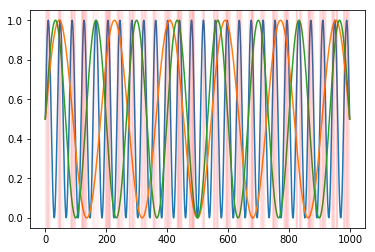

In [12]:
#fake data
N = 1000
x = np.zeros((N,3))
y = np.zeros((N,2))
x[:,0] = (np.sin(np.linspace(0,51*np.pi,N))+1)/2
x[:,1] = (np.sin(np.linspace(0,11*np.pi,N))+1)/2
x[:,2] = (np.sin(np.linspace(0,15*np.pi,N))+1)/2
plt.plot(x[:,0])
plt.plot(x[:,1])
plt.plot(x[:,2])
xx = []
yy = []
for i in range(N):
    if x[i,0]>0.5 and np.random.randint(2)>0:
        y[i,0] = 1.
        xx.append(i)
        yy.append(np.max(x[i,0]))
        plt.axvline(i,lw=0.1,c='r')
#plt.scatter(xx,yy,c='r',marker='X')
plt.show()
x = mapx(x)

### RNN-model, fig. 10.4

In [13]:
Nit = 1000
eps = 0.001

U,W,b,V,c,dU,dW,db,dV,dc,yhat,Loss = initialization(Nit)

for k in range(Nit):
    h,o,yhat[k] = prediction(b[k],c[k],U[k],V[k],W[k],x)
    Loss[k] = get_loss(y,yhat[k])
    print(k,Loss[k])
    db[k],dc[k],do,dU[k],dV[k],dW[k] = gradients(h,o,V[k],W[k],x,y,yhat[k])
    
    if k+1<Nit:
        U[k+1] = U[k] + eps*dU[k]
        W[k+1] = W[k] + eps*dW[k]
        V[k+1] = V[k] + eps*dV[k]
        b[k+1] = b[k] + eps*db[k]
        c[k+1] = c[k] + eps*dc[k]

    

0 315.310588919
1 271.247590942
2 256.617997003
3 251.377999565
4 249.355652934
5 248.533272783
6 248.187002776
7 248.037697305
8 247.972163124
9 247.94291591
10 247.929577534
11 247.923268389
12 247.920079617
13 247.918278732
14 247.917094339
15 247.916181902
16 247.915387202
17 247.914641086
18 247.913912487
19 247.913187403
20 247.912459485
21 247.911725814
22 247.910985007
23 247.910236366
24 247.909479501
25 247.908714156
26 247.907940131
27 247.907157252
28 247.906365351
29 247.905564265
30 247.904753825
31 247.903933862
32 247.903104203
33 247.902264668
34 247.901415076
35 247.900555241
36 247.899684969
37 247.898804066
38 247.89791233
39 247.897009553
40 247.896095526
41 247.895170029
42 247.89423284
43 247.893283731
44 247.892322467
45 247.891348806
46 247.890362501
47 247.889363298
48 247.888350936
49 247.887325147
50 247.886285655
51 247.885232176
52 247.884164421
53 247.88308209
54 247.881984875
55 247.88087246
56 247.87974452
57 247.878600719
58 247.877440713
59 247.876264

466 164.57027664
467 164.552486184
468 164.534800615
469 164.517218879
470 164.499739937
471 164.482362765
472 164.465086353
473 164.447909705
474 164.430831839
475 164.413851787
476 164.396968593
477 164.380181315
478 164.363489025
479 164.346890804
480 164.330385749
481 164.313972969
482 164.297651581
483 164.281420719
484 164.265279526
485 164.249227154
486 164.233262771
487 164.217385552
488 164.201594685
489 164.185889367
490 164.170268807
491 164.154732223
492 164.139278843
493 164.123907905
494 164.108618657
495 164.093410357
496 164.078282272
497 164.063233678
498 164.048263859
499 164.03337211
500 164.018557733
501 164.003820041
502 163.989158353
503 163.974571997
504 163.96006031
505 163.945622636
506 163.931258329
507 163.916966748
508 163.902747262
509 163.888599246
510 163.874522083
511 163.860515165
512 163.846577889
513 163.83270966
514 163.818909889
515 163.805177996
516 163.791513407
517 163.777915553
518 163.764383874
519 163.750917815
520 163.737516829
521 163.724180

924 160.798648048
925 160.793903743
926 160.78916004
927 160.784416839
928 160.779674042
929 160.774931546
930 160.770189251
931 160.765447056
932 160.760704856
933 160.755962549
934 160.75122003
935 160.746477194
936 160.741733936
937 160.736990149
938 160.732245725
939 160.727500557
940 160.722754536
941 160.718007551
942 160.713259493
943 160.708510249
944 160.703759708
945 160.699007756
946 160.694254279
947 160.689499163
948 160.684742291
949 160.679983547
950 160.675222813
951 160.67045997
952 160.665694899
953 160.660927479
954 160.65615759
955 160.651385107
956 160.646609909
957 160.64183187
958 160.637050865
959 160.632266767
960 160.627479449
961 160.622688782
962 160.617894637
963 160.613096882
964 160.608295387
965 160.603490016
966 160.598680638
967 160.593867116
968 160.589049314
969 160.584227095
970 160.579400319
971 160.574568848
972 160.569732539
973 160.564891251
974 160.56004484
975 160.555193161
976 160.550336069
977 160.545473416
978 160.540605053
979 160.53573083

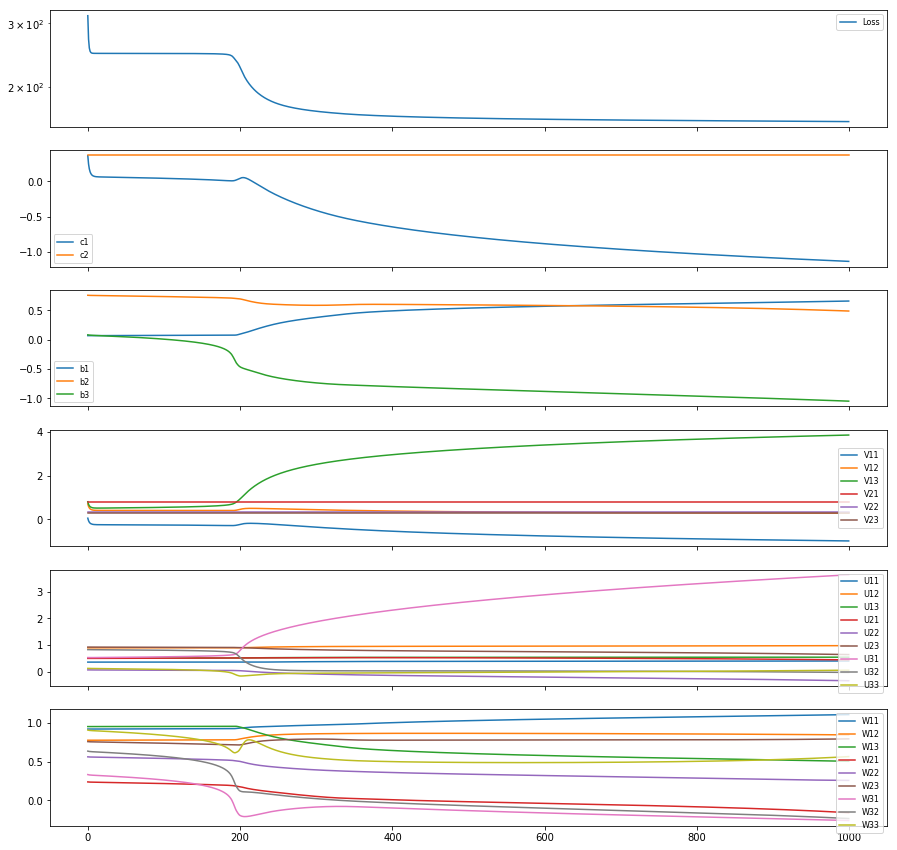

In [14]:
plot_model_evolution(Loss,b,c,U,V,W)

In [15]:
_,_,pred = prediction(b[-1],c[-1],U[-1],V[-1],W[-1],x)

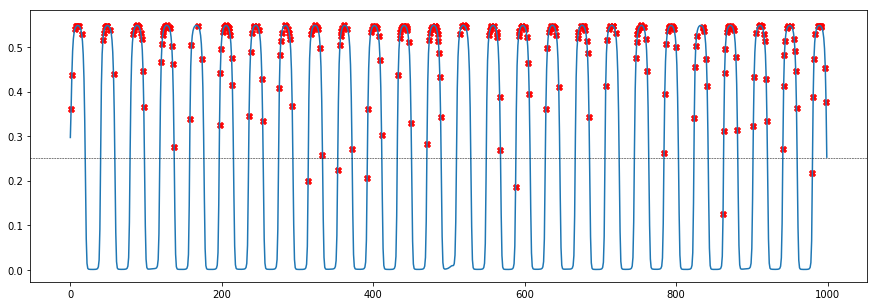

True Positives:   252
False Positives:  243
False Negatives:  6
True Negatives:   499


In [17]:
q = 0.25

plt.figure(figsize=(15,5))
plt.plot(pred[:,0])
for i in range(N):
    if y[i,0]==1.:
        plt.scatter(i,pred[i,0],c='r',marker='X')
plt.axhline(q,lw=0.5,ls='dashed',c='k')
#plt.yscale('log')
plt.show()

C = Confusionmatrix(y,pred,q)